In [1]:
import tensorflow as tf
import keras 
from keras import backend as K
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Activation,Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.applications.inception_v3 import preprocess_input
from keras.utils import to_categorical

from skimage import color, filters, exposure, morphology

from sklearn.metrics import confusion_matrix

import os
import glob

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_path = '../data/MESSIDOR_images/filtered/train'
val_path = '../data/MESSIDOR_images/filtered/val'
test_path = '../data/MESSIDOR_images/filtered/test'

In [3]:
train_batches = ImageDataGenerator(rescale=1./255)\
    .flow_from_directory(directory=train_path, target_size=(224, 224), color_mode='rgb', classes=['NoDR','DR'],
                         batch_size=len(glob.glob(train_path+'/*/*')), seed=9)

test_batches = ImageDataGenerator(rescale=1./255)\
    .flow_from_directory(directory=test_path, target_size=(224, 224), color_mode='rgb', classes=['NoDR','DR'],
                         batch_size=len(glob.glob(test_path+'/*/*')), seed=9)

val_batches = ImageDataGenerator(rescale=1./255)\
    .flow_from_directory(directory=val_path, target_size=(224, 224), color_mode='rgb', classes=['NoDR','DR'],
                         batch_size=len(glob.glob(val_path+'/*/*')), seed=9)

Found 829 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


In [4]:
train_image, train_label = next(train_batches)
test_image, test_label = next(test_batches)
val_image, val_label = next(val_batches)

In [5]:
print(len(train_label))
print(len(test_label))
print(len(val_label))

829
106
103


In [6]:
def flip_image(images):
    flipped_images = []
    for image in images:
        flipped_images.append(np.fliplr(image))
    return np.array(flipped_images)

In [7]:
test_flipped = flip_image(test_image)

In [8]:
train_flipped = flip_image(train_image)

In [9]:
val_flipped = flip_image(val_image)

In [10]:
print(len(train_flipped))
print(len(test_flipped))
print(len(val_flipped))

829
106
103


In [11]:
def plot_comparison(original, filtered, title_filtered):
    """Plots two images for comparison"""
    fig,(ax1, ax2) = plt.subplots(ncols=2, figsize=(40,40), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

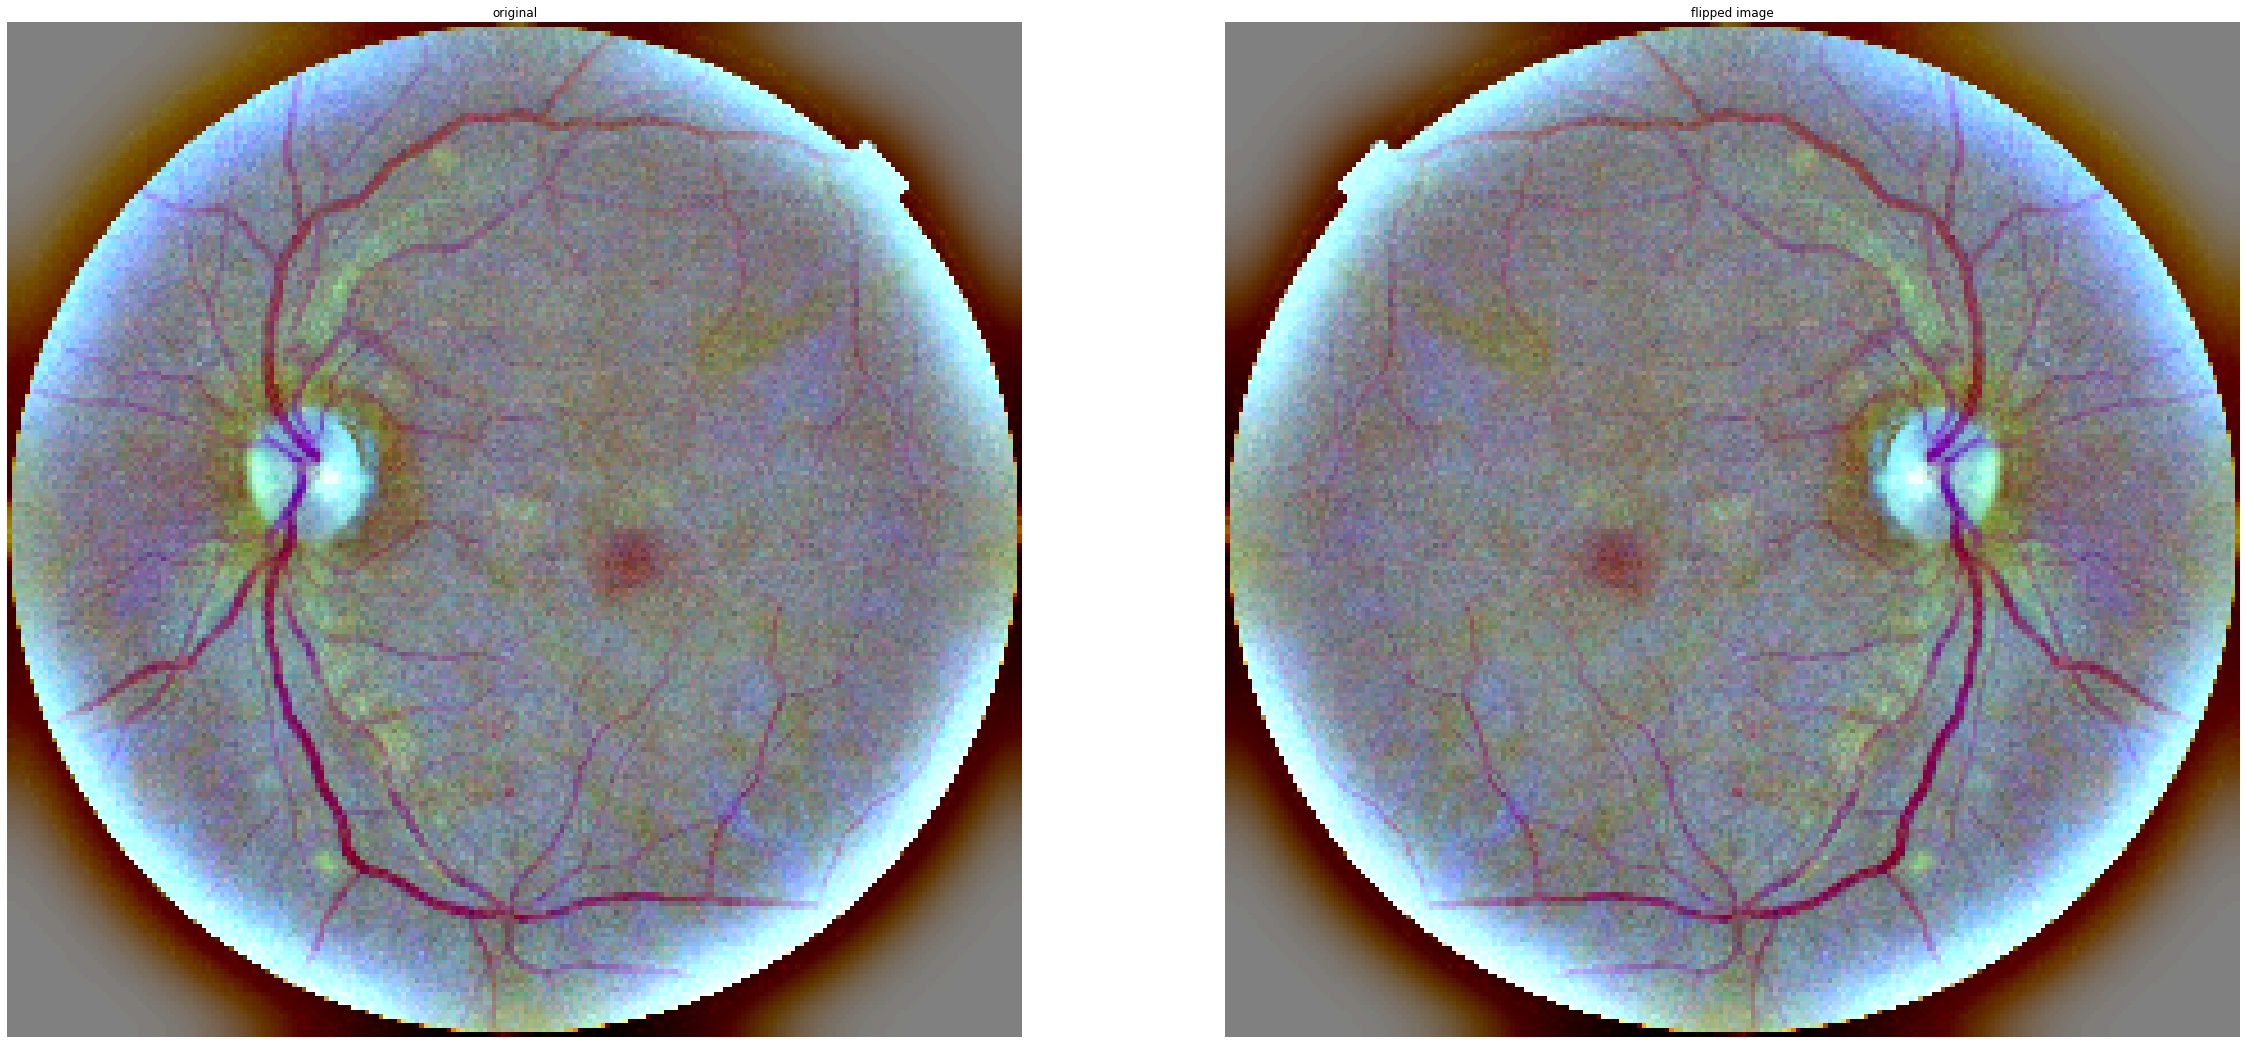

In [12]:
plot_comparison(test_image[0], test_flipped[0], 'flipped image')

In [13]:
train = np.concatenate([train_image, train_flipped])
test = np.concatenate([test_image, test_flipped])
val = np.concatenate([val_image, val_flipped])

In [14]:
train_labels = np.concatenate([train_label, train_label])
test_labels = np.concatenate([test_label, test_label])
val_labels = np.concatenate([val_label, val_label])

In [15]:
assert (len(train_labels) == len(train))
assert (len(test_labels) == len(test))
assert (len(val_labels) == len(val))

print(len(train))
print(len(test))
print(len(val))

1658
212
206


In [16]:
def display_plot(images_array, label):
    fig, axes = plt.subplots(1, 5, figsize=(25,25))
    axes = axes.flatten()  
    indexer = 0
    for image, ax in zip(images_array, axes):
        ax.set_title(label[indexer])
        indexer+=1
        ax.imshow(image)
        ax.axis('off')

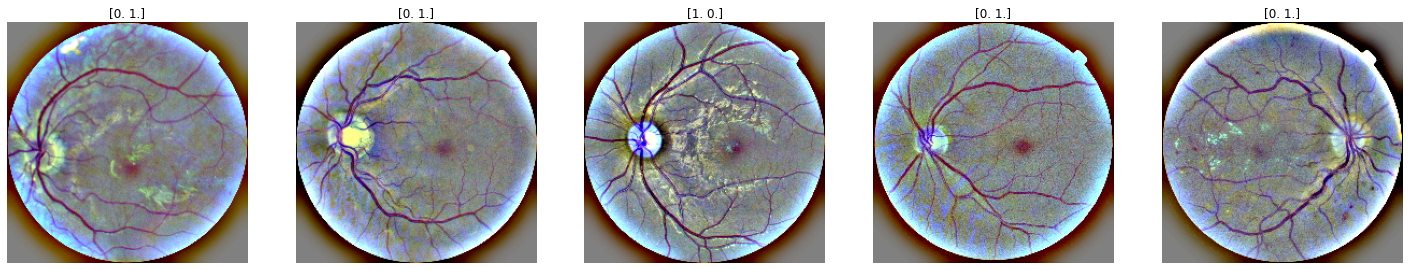

In [17]:
display_plot(train, train_labels)
plt.savefig('../figures/preprocessed_images')

# Model Construction

In [18]:
num_classes = 2

# Model 1

In [23]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3,3),input_shape=(224,224,3), padding='same', activation='relu'))
cnn1.add(MaxPooling2D())
cnn1.add(Conv2D(32, kernel_size=(3,3),padding='same', activation='relu'))
cnn1.add(MaxPooling2D())
cnn1.add(Dense(64,activation='relu'))
cnn1.add(Flatten())
cnn1.add(Dense(num_classes,activation='softmax'))
cnn1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(cnn1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dense_4 (Dense)              (None, 56, 56, 64)        2112      
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [24]:
history1 = cnn1.fit(train,
                    train_labels,
                    shuffle=True,
                    epochs=20,
                    verbose=1,
                    validation_data=(val,val_labels))

Epoch 1/20
52/52 [==============================] - 57s 1s/step - loss: 0.9949 - accuracy: 0.5133 - val_loss: 0.7146 - val_accuracy: 0.4757
Epoch 2/20
52/52 [==============================] - 52s 992ms/step - loss: 0.6761 - accuracy: 0.5850 - val_loss: 0.6650 - val_accuracy: 0.5777
Epoch 3/20
52/52 [==============================] - 51s 979ms/step - loss: 0.6433 - accuracy: 0.6381 - val_loss: 0.6269 - val_accuracy: 0.6699
Epoch 4/20
52/52 [==============================] - 49s 945ms/step - loss: 0.6445 - accuracy: 0.6152 - val_loss: 0.6167 - val_accuracy: 0.6650
Epoch 5/20
52/52 [==============================] - 50s 955ms/step - loss: 0.6191 - accuracy: 0.6490 - val_loss: 0.7911 - val_accuracy: 0.5000
Epoch 6/20
52/52 [==============================] - 49s 950ms/step - loss: 0.6030 - accuracy: 0.6761 - val_loss: 0.6350 - val_accuracy: 0.6359
Epoch 7/20
52/52 [==============================] - 49s 950ms/step - loss: 0.5473 - accuracy: 0.7183 - val_loss: 0.5756 - val_accuracy: 0.7039
Ep

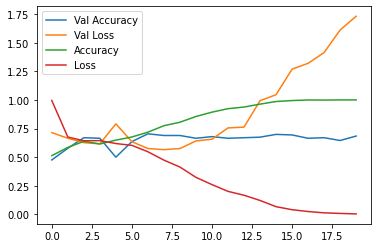

In [64]:
plt.plot(history1.history['val_accuracy'])
plt.plot(history1.history['val_loss'])
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['loss'])
plt.legend(['Val Accuracy', 'Val Loss', 'Accuracy', 'Loss'])
plt.show()

In [29]:
cnn1.evaluate(test, test_labels)

7/7 [==============================] - 2s 244ms/step - loss: 1.5042 - accuracy: 0.6745


[1.5042344331741333, 0.6745283007621765]

In [28]:
cnn1.save('../models/cnn1_accuracy')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ../models/cnn1_accuracy/assets


INFO:tensorflow:Assets written to: ../models/cnn1_accuracy/assets


# Model 2

In [30]:
cnn2 = Sequential()
cnn2.add(Conv2D(32, kernel_size=(3,3),input_shape=(224,224,3), padding='same', activation='relu'))
cnn2.add(MaxPooling2D())
cnn2.add(Conv2D(32, kernel_size=(3,3),padding='same', activation='relu'))
cnn2.add(MaxPooling2D())
cnn2.add(Flatten())
cnn2.add(Dense(64,activation='relu'))
cnn2.add(Dense(num_classes,activation='softmax'))
cnn2.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
print(cnn2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

In [32]:
history2 = cnn2.fit(train,
                    train_labels,
                    shuffle=True,
                    epochs=20,
                    verbose=1,
                    validation_data=(val,val_labels))

Epoch 1/20
52/52 [==============================] - 57s 1s/step - loss: 0.6986 - accuracy: 0.5199 - val_loss: 0.6827 - val_accuracy: 0.5388
Epoch 2/20
52/52 [==============================] - 52s 996ms/step - loss: 0.6687 - accuracy: 0.6007 - val_loss: 0.6467 - val_accuracy: 0.6456
Epoch 3/20
52/52 [==============================] - 49s 935ms/step - loss: 0.6318 - accuracy: 0.6363 - val_loss: 0.6552 - val_accuracy: 0.5728
Epoch 4/20
52/52 [==============================] - 49s 943ms/step - loss: 0.6047 - accuracy: 0.6791 - val_loss: 0.6019 - val_accuracy: 0.7039
Epoch 5/20
52/52 [==============================] - 48s 930ms/step - loss: 0.5601 - accuracy: 0.7117 - val_loss: 0.5656 - val_accuracy: 0.7039
Epoch 6/20
52/52 [==============================] - 49s 937ms/step - loss: 0.4928 - accuracy: 0.7587 - val_loss: 0.5388 - val_accuracy: 0.7087
Epoch 7/20
52/52 [==============================] - 51s 981ms/step - loss: 0.4052 - accuracy: 0.8275 - val_loss: 0.6086 - val_accuracy: 0.6650
Ep

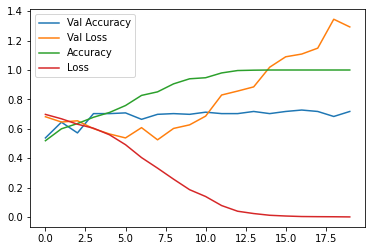

In [63]:
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['val_loss'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['loss'])
plt.legend(['Val Accuracy', 'Val Loss', 'Accuracy', 'Loss'])
plt.show()

In [41]:
cnn2.evaluate(test, test_labels)

7/7 [==============================] - 2s 250ms/step - loss: 1.3232 - accuracy: 0.7028


[1.3232311010360718, 0.7028301954269409]

In [35]:
cnn2.save('../models/cnn2_accuracy')

INFO:tensorflow:Assets written to: ../models/cnn2_accuracy/assets


INFO:tensorflow:Assets written to: ../models/cnn2_accuracy/assets


# Model 3

In [39]:
cnn3 = Sequential()
cnn3.add(Conv2D(64, kernel_size=(3,3),input_shape=(224,224,3), padding='same', activation='relu'))
cnn3.add(MaxPooling2D())
cnn3.add(Conv2D(64, kernel_size=(3,3),padding='same', activation='relu'))
cnn3.add(MaxPooling2D())
cnn3.add(Flatten())
cnn3.add(Dense(128,activation='relu'))
cnn3.add(Dense(num_classes,activation='softmax'))
cnn3.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
print(cnn3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               25690240  
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [ ]:
history3 = cnn3.fit(train,
                    train_labels,
                    shuffle=True,
                    epochs=30,
                    verbose=1,
                    validation_data=(val,val_labels))

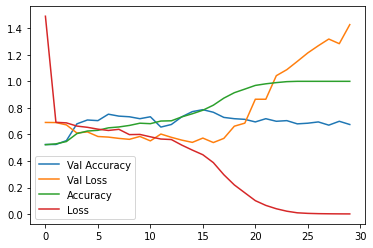

In [62]:
plt.plot(history3.history['val_accuracy'])
plt.plot(history3.history['val_loss'])
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['loss'])
plt.legend(['Val Accuracy', 'Val Loss', 'Accuracy', 'Loss'])
plt.show()

In [47]:
cnn3.evaluate(test, test_labels)

7/7 [==============================] - 4s 603ms/step - loss: 1.8452 - accuracy: 0.6840


[1.8451710939407349, 0.6839622855186462]

In [ ]:
cnn3.save('../models/cnn3_accuracy')

# Model 4

In [50]:
cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3,3),input_shape=(224,224,3), padding='same', activation='relu'))
cnn4.add(MaxPooling2D())
cnn4.add(Dropout(0.2))
cnn4.add(Conv2D(32, kernel_size=(3,3),padding='same', activation='relu'))
cnn4.add(MaxPooling2D())
cnn4.add(Dropout(0.2))
cnn4.add(Flatten())
cnn4.add(Dense(64,activation='relu'))
cnn4.add(Dense(num_classes,activation='softmax'))
cnn4.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
print(cnn4.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)           

In [51]:
history4 = cnn4.fit(train,
                    train_labels,
                    shuffle=True,
                    epochs=30,
                    verbose=1,
                    validation_data=(val,val_labels))

Epoch 1/30
52/52 [==============================] - 71s 1s/step - loss: 1.1249 - accuracy: 0.5229 - val_loss: 0.6910 - val_accuracy: 0.5437
Epoch 2/30
52/52 [==============================] - 56s 1s/step - loss: 0.6868 - accuracy: 0.5483 - val_loss: 0.6780 - val_accuracy: 0.6990
Epoch 3/30
52/52 [==============================] - 55s 1s/step - loss: 0.6732 - accuracy: 0.6025 - val_loss: 0.6614 - val_accuracy: 0.6796
Epoch 4/30
52/52 [==============================] - 53s 1s/step - loss: 0.6649 - accuracy: 0.6086 - val_loss: 0.6744 - val_accuracy: 0.6117
Epoch 5/30
52/52 [==============================] - 54s 1s/step - loss: 0.6401 - accuracy: 0.6405 - val_loss: 0.6891 - val_accuracy: 0.5728
Epoch 6/30
52/52 [==============================] - 53s 1s/step - loss: 0.6377 - accuracy: 0.6248 - val_loss: 0.6191 - val_accuracy: 0.6796
Epoch 7/30
52/52 [==============================] - 54s 1s/step - loss: 0.5899 - accuracy: 0.6864 - val_loss: 0.6164 - val_accuracy: 0.6893
Epoch 8/30
52/52 [==

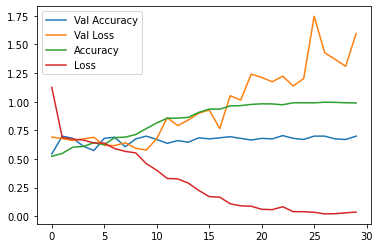

In [61]:
plt.plot(history4.history['val_accuracy'])
plt.plot(history4.history['val_loss'])
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['loss'])
plt.legend(['Val Accuracy', 'Val Loss', 'Accuracy', 'Loss'])
plt.show()

In [54]:
cnn4.evaluate(test, test_labels)

7/7 [==============================] - 1s 210ms/step - loss: 1.6334 - accuracy: 0.6840


[1.6333942413330078, 0.6839622855186462]

In [66]:
cnn4.save('../models/cnn4_accuracy')

INFO:tensorflow:Assets written to: ../models/cnn4_accuracy/assets


INFO:tensorflow:Assets written to: ../models/cnn4_accuracy/assets


# Model 5

In [55]:
cnn5 = Sequential()
cnn5.add(Conv2D(32, kernel_size=(3,3),input_shape=(224,224,3), padding='same', activation='relu'))
cnn5.add(MaxPooling2D())
cnn5.add(Conv2D(32, kernel_size=(3,3),padding='same', activation='relu'))
cnn5.add(MaxPooling2D())
cnn5.add(Flatten())
cnn5.add(Dense(64,activation='relu'))
cnn5.add(Dense(num_classes,activation='softmax'))
cnn5.compile(optimizer='adam',loss='categorical_crossentropy',metrics='AUC')
print(cnn5.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                6422592   
_________________________________________________________________
dense_19 (Dense)             (None, 2)                

In [56]:
history5 = cnn5.fit(train,
                    train_labels,
                    shuffle=True,
                    epochs=20,
                    verbose=1,
                    validation_data=(val,val_labels))

Epoch 1/20
52/52 [==============================] - 56s 1s/step - loss: 0.8380 - auc: 0.5553 - val_loss: 0.6848 - val_auc: 0.6514
Epoch 2/20
52/52 [==============================] - 49s 947ms/step - loss: 0.6862 - auc: 0.5664 - val_loss: 0.6686 - val_auc: 0.7086
Epoch 3/20
52/52 [==============================] - 49s 938ms/step - loss: 0.6657 - auc: 0.6350 - val_loss: 0.6343 - val_auc: 0.7503
Epoch 4/20
52/52 [==============================] - 48s 919ms/step - loss: 0.6236 - auc: 0.7132 - val_loss: 0.6094 - val_auc: 0.7494
Epoch 5/20
52/52 [==============================] - 48s 914ms/step - loss: 0.6115 - auc: 0.7266 - val_loss: 0.6465 - val_auc: 0.6822
Epoch 6/20
52/52 [==============================] - 48s 930ms/step - loss: 0.5898 - auc: 0.7523 - val_loss: 0.5842 - val_auc: 0.7697
Epoch 7/20
52/52 [==============================] - 49s 937ms/step - loss: 0.5355 - auc: 0.8072 - val_loss: 0.8953 - val_auc: 0.6285
Epoch 8/20
52/52 [==============================] - 48s 920ms/step - los

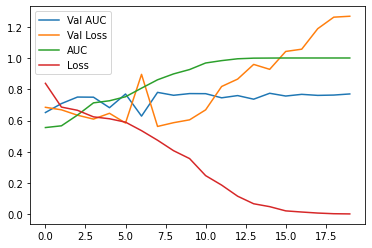

In [59]:
plt.plot(history5.history['val_auc'])
plt.plot(history5.history['val_loss'])
plt.plot(history5.history['auc'])
plt.plot(history5.history['loss'])
plt.legend(['Val AUC', 'Val Loss', 'AUC', 'Loss'])
plt.show()

In [65]:
cnn5.evaluate(test, test_labels)

7/7 [==============================] - 1s 207ms/step - loss: 1.2588 - auc: 0.7661


[1.258795976638794, 0.7660866379737854]

In [67]:
cnn5.save('../models/cnn5_auc')

INFO:tensorflow:Assets written to: ../models/cnn5_auc/assets


INFO:tensorflow:Assets written to: ../models/cnn5_auc/assets


# Evaluation

In [153]:
print(str(round((train_labels[:,1].sum() / len(train_labels) * 100), 2))+'% of the images have DR')

47.29% of the images have DR


In [154]:
y_pred = cnn5.predict(test)
rounded_pred = np.round(y_pred)

In [155]:
cf_matrix = confusion_matrix(y_true=test_labels[:,-1], y_pred=np.argmax(rounded_pred, axis=-1))

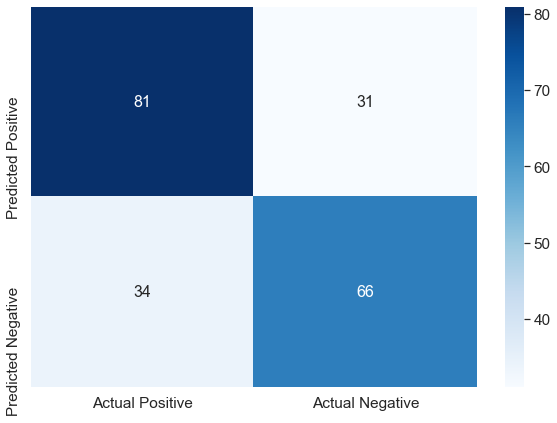

In [156]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='.4g',
            xticklabels=['Actual Positive', 'Actual Negative'], 
            yticklabels=['Predicted Positive', 'Predicted Negative'])

plt.savefig('../figures/modelcm.png')

In [157]:
missed_images = []
missed_label = []
indexer = 0
for image in test:
    if (np.argmax(rounded_pred, axis=-1)[indexer] + test_labels[:,-1][indexer]) == 1:
        missed_images.append(image)
        if test_labels[:,-1][indexer] == 1:
            missed_label.append('DR')
        else:
            missed_label.append('No DR')
        
    indexer+=1

In [172]:
assert (len(missed_images) == len(missed_label))
print(len(missed_label))

65


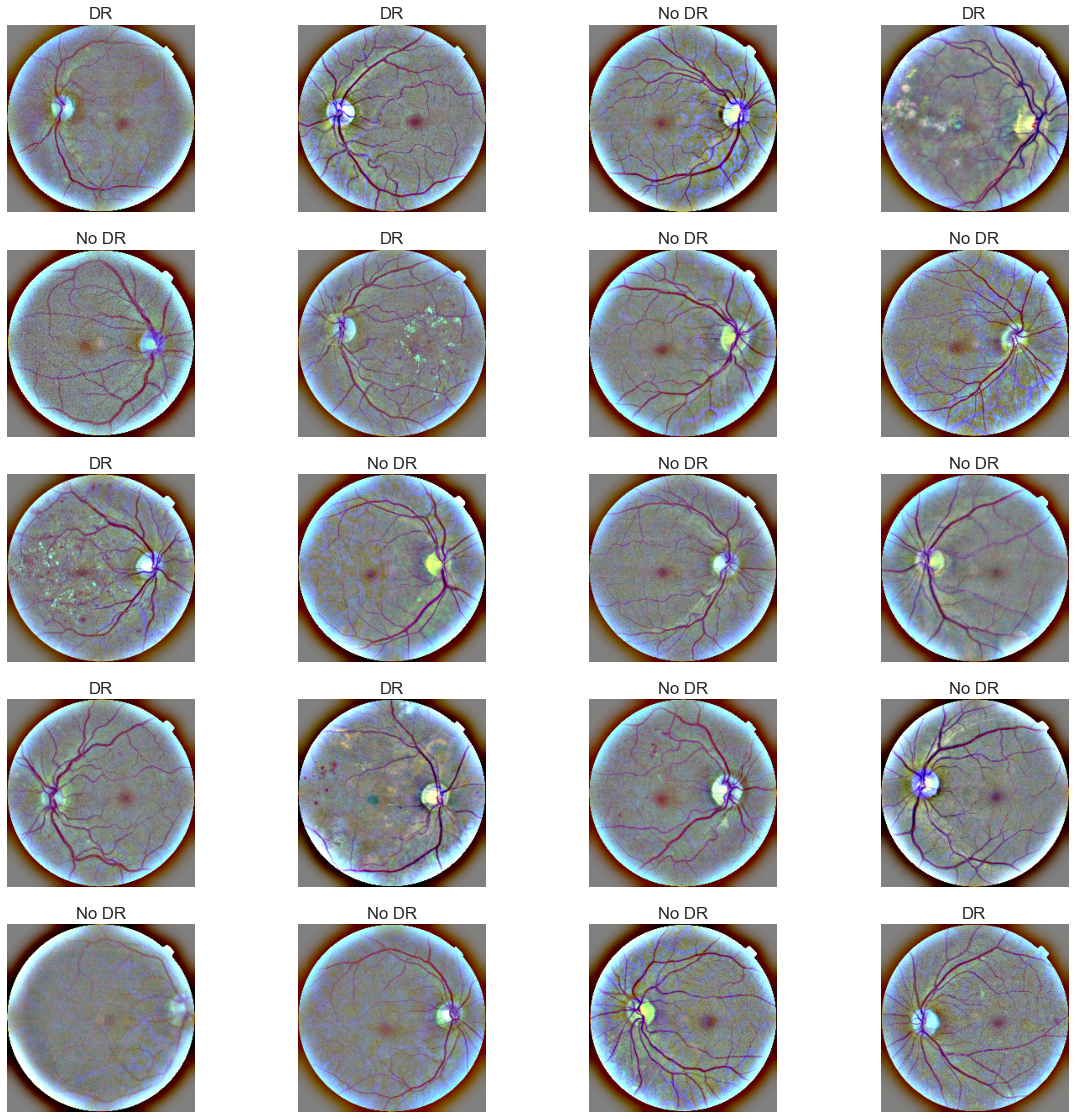

In [174]:
fig,axes = plt.subplots(5,4,figsize=(20,20))
i=0

for row in axes:
    for col in row:
        col.imshow(missed_images[i])
        col.axis('off')
        col.set_title(missed_label[i])
        i+=1
        
plt.savefig('../figures/missed_images.png')